In [39]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [34]:
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)  # se non esiste la crea

In [35]:
ticker = "SPY"  # ETF che segue l'indice S&P500
#data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
#data.head()

In [36]:
file_path = os.path.join(data_dir, f"{ticker.lower()}.csv")
#data.to_csv(file_path)
#print(f"Dati salvati in {file_path}")

In [37]:
df = pd.read_csv("../data/spy.csv", index_col=0, parse_dates=True)

In [7]:
# Impostazioni grafiche
plt.style.use("seaborn-v0_8")
sns.set(rc={'figure.figsize':(12,6)})

In [8]:
print(df.shape)
print(df.info())
print(df.describe())

(3774, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2010-01-04 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3774 non-null   float64
 1   High    3774 non-null   float64
 2   Low     3774 non-null   float64
 3   Open    3774 non-null   float64
 4   Volume  3774 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB
None
             Close         High          Low         Open        Volume
count  3774.000000  3774.000000  3774.000000  3774.000000  3.774000e+03
mean    247.221052   248.505442   245.738583   247.181299  1.118054e+08
std     132.267890   132.943101   131.499525   132.259572  6.908714e+07
min      77.803253    78.732021    76.988656    78.496025  2.027000e+07
25%     138.376450   138.741324   137.862513   138.207561  6.614835e+07
50%     213.382248   214.029923   212.628348   213.452349  9.190805e+07
75%     362.305275   365.076797   358.426812  

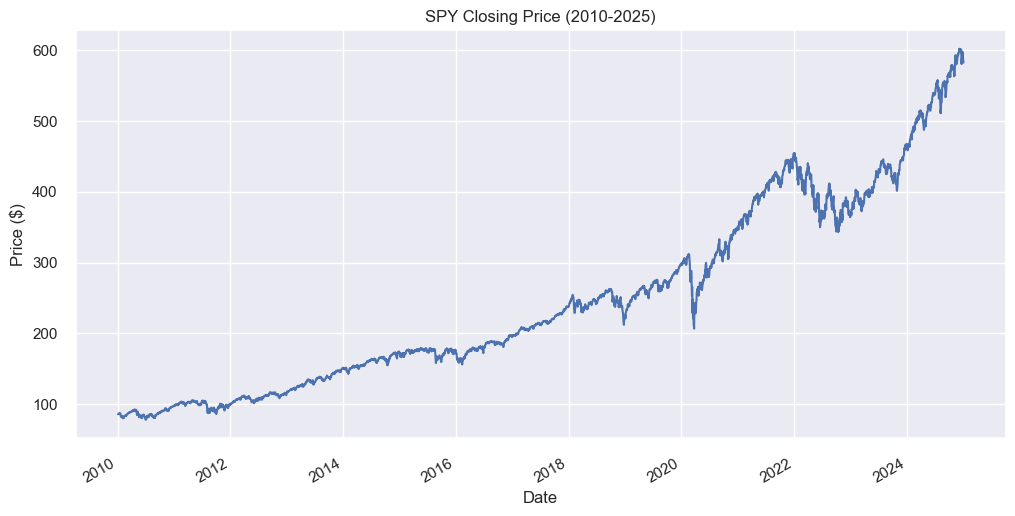

In [9]:
df["Close"].plot(title="SPY Closing Price (2010-2025)")
plt.ylabel("Price ($)")
plt.show()

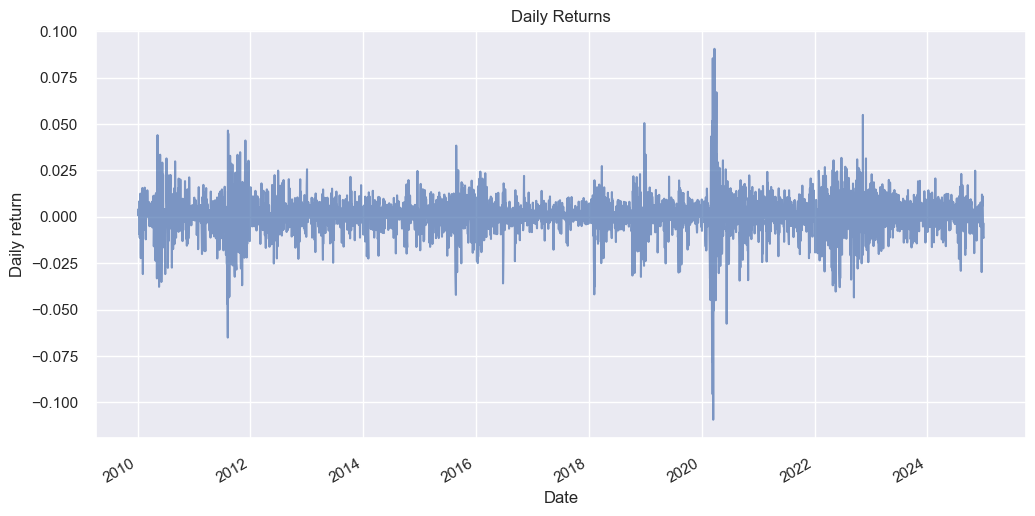

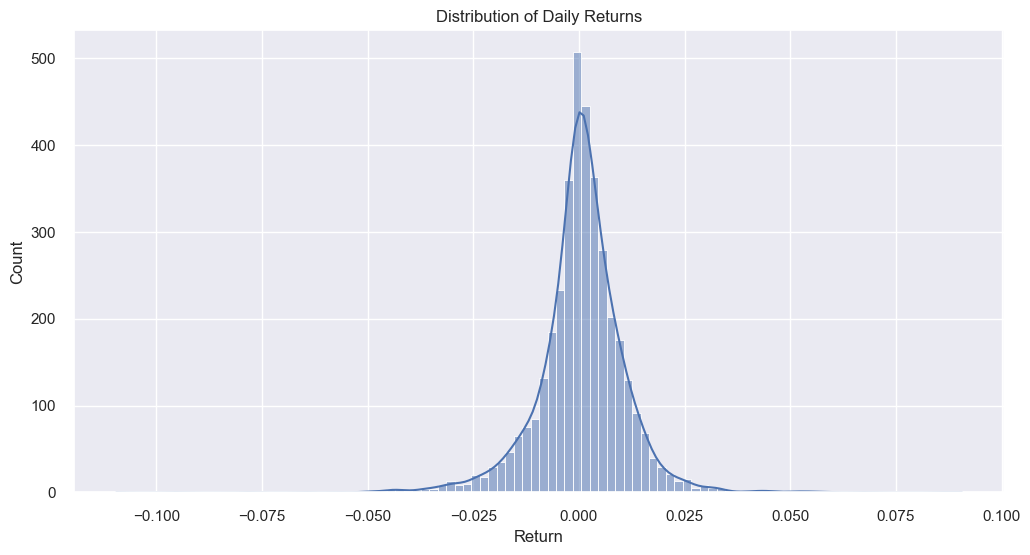

In [10]:
df["Return"] = df["Close"].pct_change()
df["Return"].plot(title="Daily Returns", alpha=0.7)
plt.ylabel("Daily return")
plt.show()

# Distribuzione rendimenti
sns.histplot(df["Return"].dropna(), bins=100, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

df["RollingVol"] = df["Return"].rolling(30).std()
df["RollingVol"].plot(title="30-Day Rolling Volatility")
plt.ylabel("Volatility (std of returns)")
plt.show()

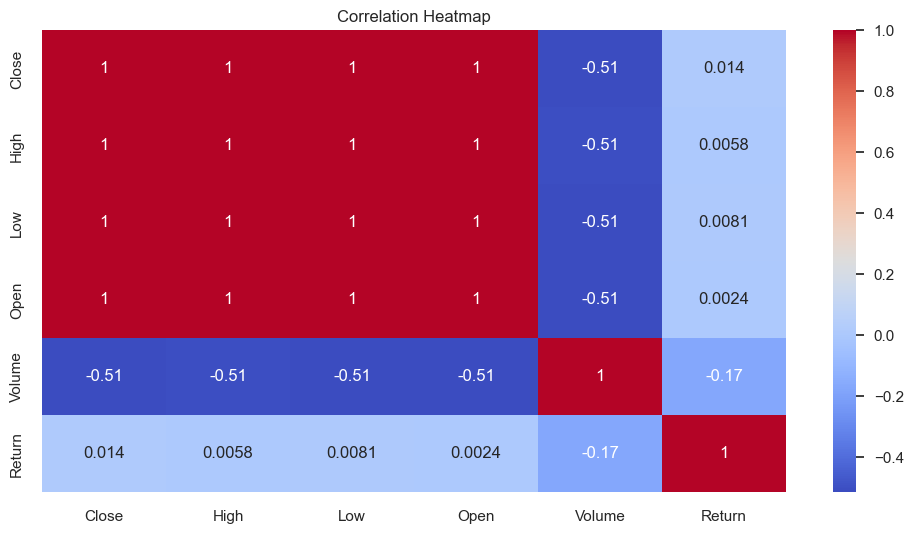

In [11]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### FEATURE ENGINEERING AND TRAINING

=== FINANCIAL FORECASTING PIPELINE ===
Task: classification
Dataset shape iniziale: (3774, 5)

1. Creating advanced features...
2. Handling outliers...

3. Running walk-forward validation...
Dataset shape dopo pulizia: (3754, 54)
Features utilizzate: 53
Walk-forward da indice 1877 a 3753 (1876 predizioni)


Walk-forward validation: 100%|██████████████| 1876/1876 [06:51<00:00,  4.56it/s]



Completate 1876 predizioni

4. Model evaluation:
=== CLASSIFICATION METRICS ===
Accuracy: 0.511
Precision (Up): 0.550
Recall (Up): 0.655
F1-Score (Up): 0.598
Hit rate (prob > 0.5): 0.511 (1241 trades)
Hit rate (prob > 0.55): 0.487 (1010 trades)
Hit rate (prob > 0.6): 0.478 (775 trades)
Hit rate (prob > 0.65): 0.466 (555 trades)

5. Generating plots...


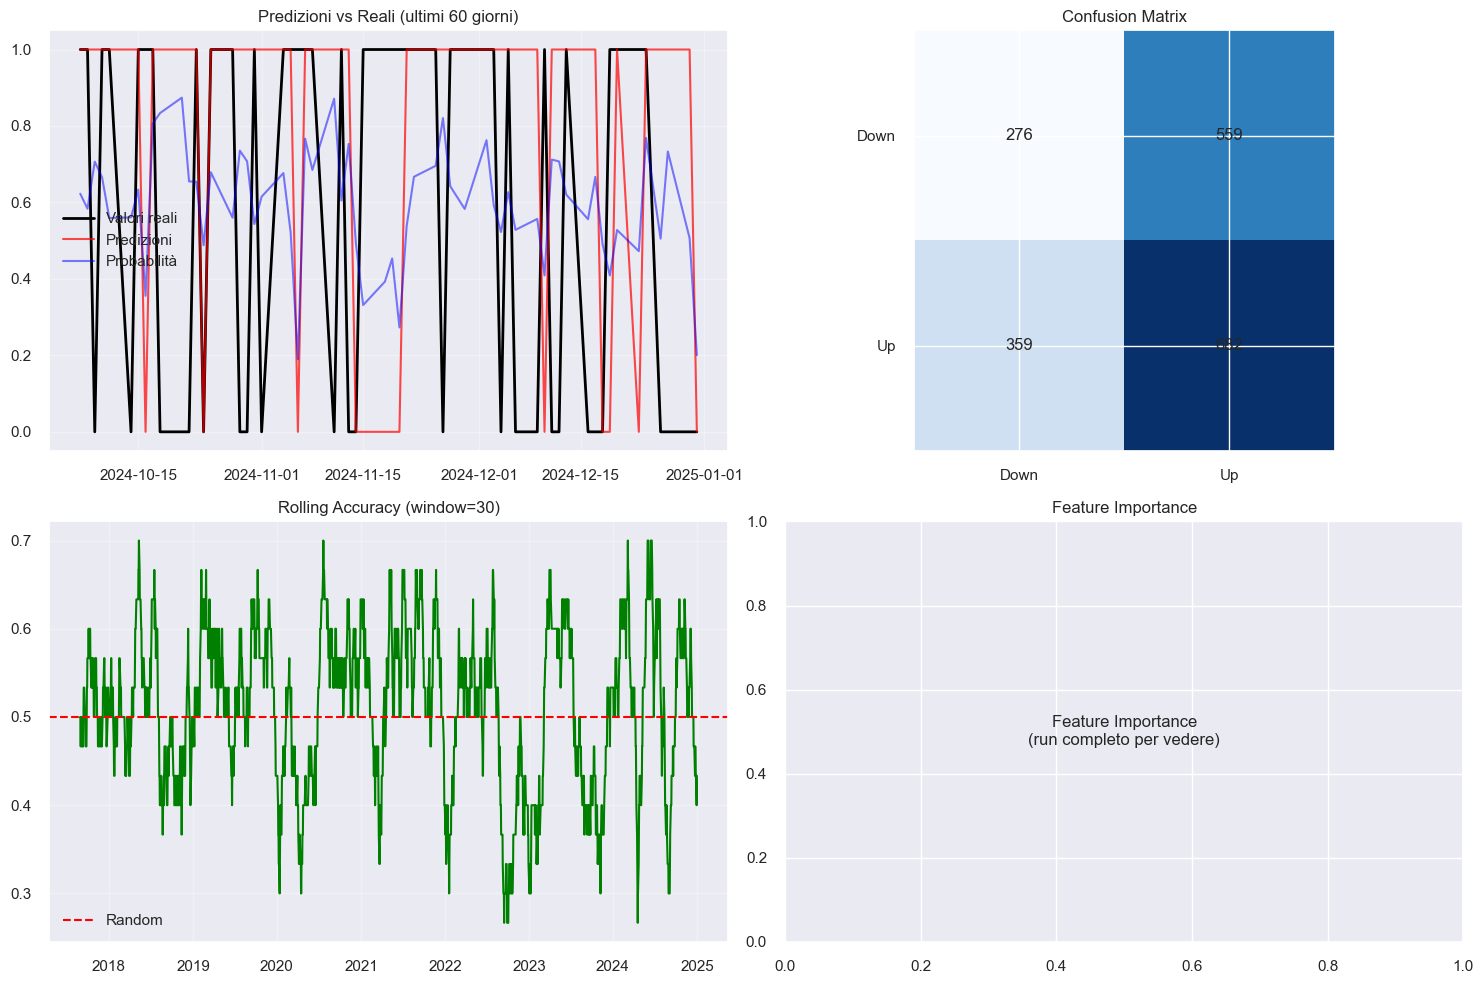

=== FINANCIAL FORECASTING PIPELINE ===
Task: regression
Dataset shape iniziale: (3774, 5)

1. Creating advanced features...
2. Handling outliers...

3. Running walk-forward validation...
Dataset shape dopo pulizia: (3753, 54)
Features utilizzate: 53
Walk-forward da indice 1876 a 3752 (1876 predizioni)


Walk-forward validation: 100%|██████████████| 1876/1876 [06:32<00:00,  4.78it/s]



Completate 1876 predizioni

4. Model evaluation:
=== REGRESSION METRICS ===
RMSE: 0.010803
MAE: 0.007791
Directional Accuracy: 0.494

5. Generating plots...


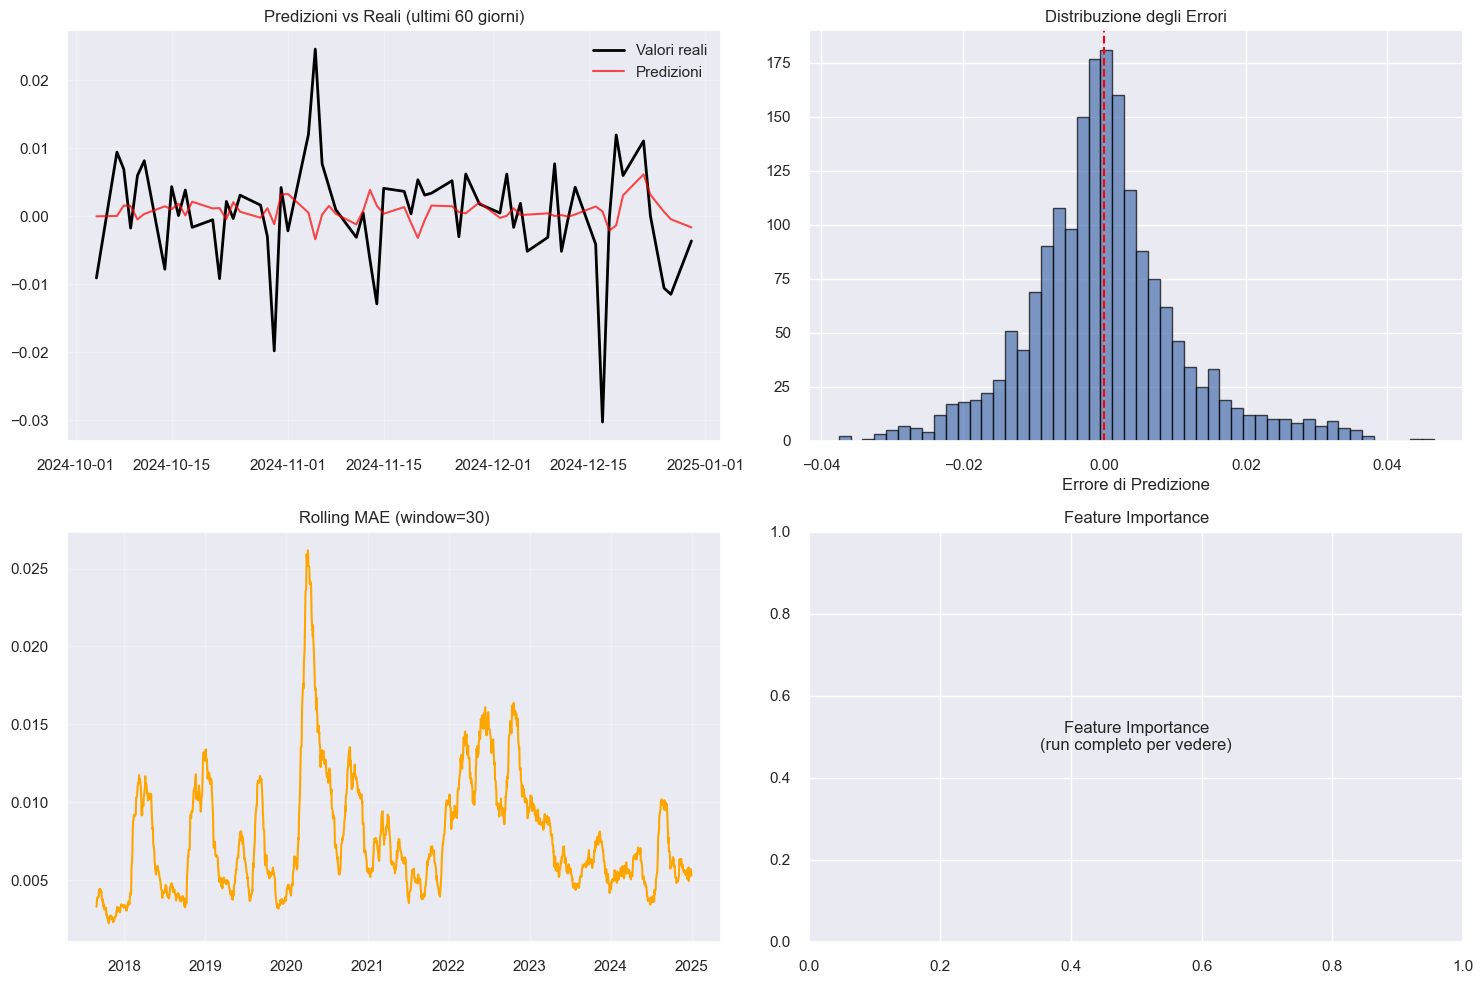

Codice pronto! Usa run_financial_forecasting(df, task='classification') per eseguire


In [40]:
def create_advanced_features(df):
    """
    Crea features tecniche avanzate per il forecasting finanziario
    """
    df = df.copy()
    
    # --- Basic Returns ---
    df["Return"] = df["Close"].pct_change()
    df["Log_Return"] = np.log(df["Close"]).diff()
    
    # --- TARGET: Log Return di domani (più simmetrico) ---
    df["Target_Return"] = df["Log_Return"].shift(-1)
    
    # --- TARGET CLASSIFICATION: Direzione del movimento ---
    df["Target_Direction"] = np.where(df["Target_Return"] > 0, 1, 0)
    
    # --- Volatility Features ---
    df["Volatility_5"] = df["Return"].rolling(5).std()
    df["Volatility_10"] = df["Return"].rolling(10).std()
    df["Volatility_20"] = df["Return"].rolling(20).std()
    
    # --- Price-based features (senza Close per evitare leakage) ---
    df["HL_Spread"] = (df["High"] - df["Low"]) / df["Close"].shift(1)  # High-Low spread normalizzato
    df["OC_Gap"] = (df["Open"] - df["Close"].shift(1)) / df["Close"].shift(1)  # Overnight gap
    
    # --- Volume Features ---
    df["Volume_MA_5"] = df["Volume"].rolling(5).mean()
    df["Volume_Ratio"] = df["Volume"] / df["Volume_MA_5"]
    df["Price_Volume"] = df["Return"] * np.log(df["Volume"] + 1)  # Price-Volume relationship
    
    # --- Technical Indicators (usando talib se disponibile, altrimenti manuale) ---
    try:
        # RSI
        df["RSI_14"] = talib.RSI(df["Close"], timeperiod=14)
        # MACD
        macd, macd_signal, macd_hist = talib.MACD(df["Close"])
        df["MACD"] = macd
        df["MACD_Signal"] = macd_signal
        df["MACD_Hist"] = macd_hist
        # Bollinger Bands
        bb_upper, bb_middle, bb_lower = talib.BBANDS(df["Close"])
        df["BB_Position"] = (df["Close"] - bb_lower) / (bb_upper - bb_lower)
    except:
        # Implementazione manuale se talib non disponibile
        # RSI manuale
        delta = df["Close"].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / avg_loss
        df["RSI_14"] = 100 - (100 / (1 + rs))
        
        # MACD manuale
        ema_12 = df["Close"].ewm(span=12).mean()
        ema_26 = df["Close"].ewm(span=26).mean()
        df["MACD"] = ema_12 - ema_26
        df["MACD_Signal"] = df["MACD"].ewm(span=9).mean()
        df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]
        
        # Bollinger Bands manuale
        bb_middle = df["Close"].rolling(20).mean()
        bb_std = df["Close"].rolling(20).std()
        bb_upper = bb_middle + (bb_std * 2)
        bb_lower = bb_middle - (bb_std * 2)
        df["BB_Position"] = (df["Close"] - bb_lower) / (bb_upper - bb_lower)
    
    # --- Lag Features (solo su returns e volume, NON su prezzi) ---
    for lag in [1, 2, 3, 5, 10]:
        df[f"Return_lag{lag}"] = df["Return"].shift(lag)
        df[f"Volatility_lag{lag}"] = df["Volatility_5"].shift(lag)
        df[f"Volume_Ratio_lag{lag}"] = df["Volume_Ratio"].shift(lag)
    
    # --- Rolling Statistics sui Returns ---
    for window in [5, 10, 20]:
        df[f"Return_MA_{window}"] = df["Return"].rolling(window).mean()
        df[f"Return_Std_{window}"] = df["Return"].rolling(window).std()
        df[f"Return_Skew_{window}"] = df["Return"].rolling(window).skew()
        df[f"Return_Kurt_{window}"] = df["Return"].rolling(window).kurt()
    
    # --- Time Features ---
    df["DayOfWeek"] = df.index.dayofweek
    df["MonthOfYear"] = df.index.month
    df["IsMonthEnd"] = (df.index == df.index.to_period('M').end_time).astype(int)
    df["IsYearEnd"] = (df.index.month == 12) & (df.index.day >= 28)
    
    # --- Momentum Features ---
    for period in [5, 10, 20]:
        df[f"Momentum_{period}"] = df["Close"] / df["Close"].shift(period) - 1
        df[f"ROC_{period}"] = df["Close"].pct_change(period)
    
    return df

# ====================================================
# 2. OUTLIER DETECTION E GESTIONE
# ====================================================

def handle_outliers(df, columns, method='winsorize', threshold=3):
    """
    Gestisce gli outliers nei dati finanziari
    """
    df = df.copy()
    
    for col in columns:
        if col in df.columns:
            if method == 'winsorize':
                # Winsorizzazione (cap ai percentili)
                q01, q99 = df[col].quantile([0.01, 0.99])
                df[col] = df[col].clip(q01, q99)
            elif method == 'zscore':
                # Rimozione basata su z-score
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                df.loc[z_scores > threshold, col] = np.nan
    
    return df

# ====================================================
# 3. WALK-FORWARD VALIDATION MIGLIORATO
# ====================================================

def walk_forward_validation(df, target_col='Target_Direction', task='classification', 
                          initial_train_frac=0.5, min_train_samples=252):
    """
    Walk-forward validation migliorato per forecasting finanziario
    """
    
    # Feature columns (escludiamo Close e target)
    exclude_cols = ['Close', 'Target_Return', 'Target_Direction', 'Open', 'High', 'Low']
    feature_cols = [col for col in df.columns if col not in exclude_cols and not col.startswith('Target')]
    
    # Rimuovi NaN
    df_clean = df[feature_cols + [target_col]].dropna()
    
    print(f"Dataset shape dopo pulizia: {df_clean.shape}")
    print(f"Features utilizzate: {len(feature_cols)}")
    
    # Setup walk-forward
    n = len(df_clean)
    start_train_idx = max(int(n * initial_train_frac), min_train_samples)
    positions = list(range(start_train_idx, n-1))
    
    print(f"Walk-forward da indice {start_train_idx} a {n-1} ({len(positions)} predizioni)")
    
    # Containers per risultati
    results = []
    feature_importance_list = []
    
    # Walk-forward loop
    for pos in tqdm(positions, desc="Walk-forward validation"):
        try:
            # Train set: tutto fino alla posizione corrente
            train_df = df_clean.iloc[:pos+1]
            # Test: riga successiva
            test_df = df_clean.iloc[pos+1:pos+2]
            
            if len(test_df) == 0:
                continue
                
            X_train = train_df[feature_cols]
            y_train = train_df[target_col]
            X_test = test_df[feature_cols]
            y_true = test_df[target_col].iloc[0]
            
            # Handle NaN in features
            X_train = X_train.fillna(X_train.median())
            X_test = X_test.fillna(X_train.median())  # Use train median for test
            
            # Model setup
            if task == 'classification':
                model = lgb.LGBMClassifier(
                    objective='binary',
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=6,
                    num_leaves=31,
                    feature_fraction=0.8,
                    bagging_fraction=0.8,
                    random_state=42,
                    verbose=-1
                )
            else:  # regression
                model = lgb.LGBMRegressor(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=6,
                    num_leaves=31,
                    feature_fraction=0.8,
                    bagging_fraction=0.8,
                    random_state=42,
                    verbose=-1
                )
            
            # Fit e predizione
            model.fit(X_train, y_train)
            
            if task == 'classification':
                y_pred = model.predict(X_test)[0]
                y_prob = model.predict_proba(X_test)[0][1]  # Probabilità classe 1
            else:
                y_pred = model.predict(X_test)[0]
                y_prob = None
            
            # Salva risultati
            result = {
                'date': test_df.index[0],
                'y_true': y_true,
                'y_pred': y_pred,
                'train_size': len(train_df)
            }
            
            if y_prob is not None:
                result['y_prob'] = y_prob
                
            results.append(result)
            
            # Feature importance (ogni 50 iterazioni per efficienza)
            if pos % 50 == 0:
                importance = pd.DataFrame({
                    'feature': feature_cols,
                    'importance': model.feature_importances_,
                    'date': test_df.index[0]
                })
                feature_importance_list.append(importance)
                
        except Exception as e:
            print(f"Errore alla posizione {pos}: {e}")
            continue
    
    # Converti risultati in DataFrame
    results_df = pd.DataFrame(results).set_index('date')
    
    return results_df, feature_importance_list, feature_cols

# ====================================================
# 4. METRICHE DI VALUTAZIONE FINANZIARIE
# ====================================================

def evaluate_financial_model(results_df, task='classification'):
    """
    Calcola metriche specifiche per modelli finanziari
    """
    
    if task == 'classification':
        # Accuracy classica
        accuracy = accuracy_score(results_df['y_true'], results_df['y_pred'])
        
        # Classification report
        report = classification_report(results_df['y_true'], results_df['y_pred'], 
                                     target_names=['Down', 'Up'], output_dict=True)
        
        print("=== CLASSIFICATION METRICS ===")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision (Up): {report['Up']['precision']:.3f}")
        print(f"Recall (Up): {report['Up']['recall']:.3f}")
        print(f"F1-Score (Up): {report['Up']['f1-score']:.3f}")
        
        # Trading simulation (se hai probabilità)
        if 'y_prob' in results_df.columns:
            # Strategia: compra se prob > 0.55, vendi se prob < 0.45
            results_df['signal'] = np.where(results_df['y_prob'] > 0.55, 1,
                                  np.where(results_df['y_prob'] < 0.45, -1, 0))
            
            # Hit rate per diversi threshold
            for threshold in [0.5, 0.55, 0.6, 0.65]:
                signals = (results_df['y_prob'] > threshold).astype(int)
                hit_rate = accuracy_score(results_df['y_true'], signals)
                n_trades = signals.sum()
                print(f"Hit rate (prob > {threshold}): {hit_rate:.3f} ({n_trades} trades)")
        
    else:  # regression
        rmse = np.sqrt(mean_squared_error(results_df['y_true'], results_df['y_pred']))
        mae = mean_absolute_error(results_df['y_true'], results_df['y_pred'])
        
        # Directional accuracy
        dir_true = np.sign(results_df['y_true'])
        dir_pred = np.sign(results_df['y_pred'])
        dir_acc = (dir_true == dir_pred).mean()
        
        print("=== REGRESSION METRICS ===")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"Directional Accuracy: {dir_acc:.3f}")

# ====================================================
# 5. PLOTTING AVANZATO
# ====================================================

def plot_results(results_df, task='classification', n_plot=60):
    """
    Plot dei risultati con analisi avanzata
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Time series delle predizioni
    sub = results_df.tail(n_plot)
    axes[0,0].plot(sub.index, sub['y_true'], label='Valori reali', color='black', linewidth=2)
    
    if task == 'classification':
        axes[0,0].plot(sub.index, sub['y_pred'], label='Predizioni', color='red', alpha=0.7)
        if 'y_prob' in sub.columns:
            axes[0,0].plot(sub.index, sub['y_prob'], label='Probabilità', color='blue', alpha=0.5)
    else:
        axes[0,0].plot(sub.index, sub['y_pred'], label='Predizioni', color='red', alpha=0.7)
    
    axes[0,0].set_title(f'Predizioni vs Reali (ultimi {n_plot} giorni)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Distribuzione degli errori
    if task == 'regression':
        errors = results_df['y_pred'] - results_df['y_true']
        axes[0,1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
        axes[0,1].axvline(0, color='red', linestyle='--')
        axes[0,1].set_title('Distribuzione degli Errori')
        axes[0,1].set_xlabel('Errore di Predizione')
    else:
        # Confusion matrix come heatmap
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(results_df['y_true'], results_df['y_pred'])
        im = axes[0,1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[0,1].set_title('Confusion Matrix')
        tick_marks = [0, 1]
        axes[0,1].set_xticks(tick_marks)
        axes[0,1].set_yticks(tick_marks)
        axes[0,1].set_xticklabels(['Down', 'Up'])
        axes[0,1].set_yticklabels(['Down', 'Up'])
        # Aggiungi testo
        for i in range(2):
            for j in range(2):
                axes[0,1].text(j, i, str(cm[i, j]), ha="center", va="center")
    
    # Plot 3: Rolling accuracy/performance
    window = min(30, len(results_df) // 10)
    if task == 'classification':
        rolling_acc = results_df['y_true'].rolling(window).apply(
            lambda x: accuracy_score(x, results_df['y_pred'].loc[x.index])
        )
        axes[1,0].plot(rolling_acc.index, rolling_acc, color='green')
        axes[1,0].set_title(f'Rolling Accuracy (window={window})')
        axes[1,0].axhline(0.5, color='red', linestyle='--', label='Random')
    else:
        rolling_mae = results_df.apply(
            lambda x: mean_absolute_error([x['y_true']], [x['y_pred']]), axis=1
        ).rolling(window).mean()
        axes[1,0].plot(rolling_mae.index, rolling_mae, color='orange')
        axes[1,0].set_title(f'Rolling MAE (window={window})')
    
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend()
    
    # Plot 4: Feature importance (se disponibile)
    axes[1,1].text(0.5, 0.5, 'Feature Importance\n(run completo per vedere)', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()

# ====================================================
# 6. MAIN EXECUTION
# ====================================================

def run_financial_forecasting(df, task='classification'):
    """
    Esegue l'intero pipeline di forecasting finanziario
    """
    
    print("=== FINANCIAL FORECASTING PIPELINE ===")
    print(f"Task: {task}")
    print(f"Dataset shape iniziale: {df.shape}")
    
    # 1. Feature engineering
    print("\n1. Creating advanced features...")
    df_features = create_advanced_features(df)
    
    # 2. Gestione outliers
    print("2. Handling outliers...")
    return_cols = [col for col in df_features.columns if 'Return' in col or 'Volatility' in col]
    df_clean = handle_outliers(df_features, return_cols, method='winsorize')
    
    # 3. Walk-forward validation
    print("\n3. Running walk-forward validation...")
    target_col = 'Target_Direction' if task == 'classification' else 'Target_Return'
    results_df, importance_list, feature_cols = walk_forward_validation(
        df_clean, target_col=target_col, task=task
    )
    
    print(f"\nCompletate {len(results_df)} predizioni")
    
    # 4. Evaluation
    print("\n4. Model evaluation:")
    evaluate_financial_model(results_df, task=task)
    
    # 5. Plotting
    print("\n5. Generating plots...")
    plot_results(results_df, task=task)
    
    return results_df, importance_list, feature_cols

# ====================================================
# UTILIZZO:
# ====================================================

# Per classification (predire direzione):
results_class, importance_class, features = run_financial_forecasting(df, task='classification')

# Per regression (predire return):
results_reg, importance_reg, features = run_financial_forecasting(df, task='regression')

print("Codice pronto! Usa run_financial_forecasting(df, task='classification') per eseguire")